#  Finding the Tortuosity ($\tau$) of an Image Using tortuosity_fd

In this tutorial, we will walk through how to use tortuosity_fd to calculate the tortuosity of an image using a finite difference method. The function takes a binary image to analyze with "True" to indicate the phase of interest as well as the axis along which to find the tortuosity.

## Algortihm Description


1. ``tortuosity_fd`` starts by calculating the porosity of the image. 
<br><br>
$$ \epsilon_{orginal} = \frac{\sum_{i = 0}^{N_{x}}\sum_{j = 0}^{N_{y}}im_{ij}}{N_{x}\cdot N_{y}} $$
<br><br>
2. The second step is to remove non-percolating paths between the inlet and the outlet. This is done by using ``trim_nonpercolating_paths``. The description of this filter can be found [here.](https://porespy.org/examples/filters/reference/trim_nonpercolating_paths.html?highlight=trim_nonpercolating_paths)
<br><br>
3. The new porosity is calculated after trimming the non-percolating pores using the same equation as step 1.
<br><br>
$$ \epsilon_{eff} = \frac{\sum_{i = 0}^{N_{x}}\sum_{j = 0}^{N_{y}}im_{ij}}{N_{x}\cdot N_{y}} $$
<br><br>
4. A cubic network is generated using openpnm and is used as an orthogonal grid.
<br><br>
5. A dummy phase is created, and openpnm's Fickian diffusion algorithm (``op.algorithms.FickianDiffusion``) is applied.
<br><br>
6. The inlet concentration and throat diffusive conductance are set to 1.0, and the outlet concentration is set to 0.
<br><br>
7. Using the rate calculated from the Fickian diffusion algorithm, the effective diffusion coefficient is then calculated from the formula: <br><br>
$$ D_{Eff} = \frac{\dot{\vec{N}} \cdot (L-1)}{A \cdot \Delta C} $$
<br><br>
8. The subsequent tortuosity is finally calculated using: <br><br>
$$\tau = \frac{D_{AB}}{D_{Eff}} \cdot \varepsilon_{Eff} $$
 <br><br>
9. All useful results are then compiled into a Results object. 

 ### Importing Packages

In [1]:
import matplotlib.pyplot as plt
import porespy as ps
import numpy as np

ps.visualization.set_mpl_style()

### Generating the image:

For the purposes of this tutorial, we will generate a 200 x 200 pixel image with a target porosity of 0.5.

(-0.5, 199.5, -0.5, 199.5)

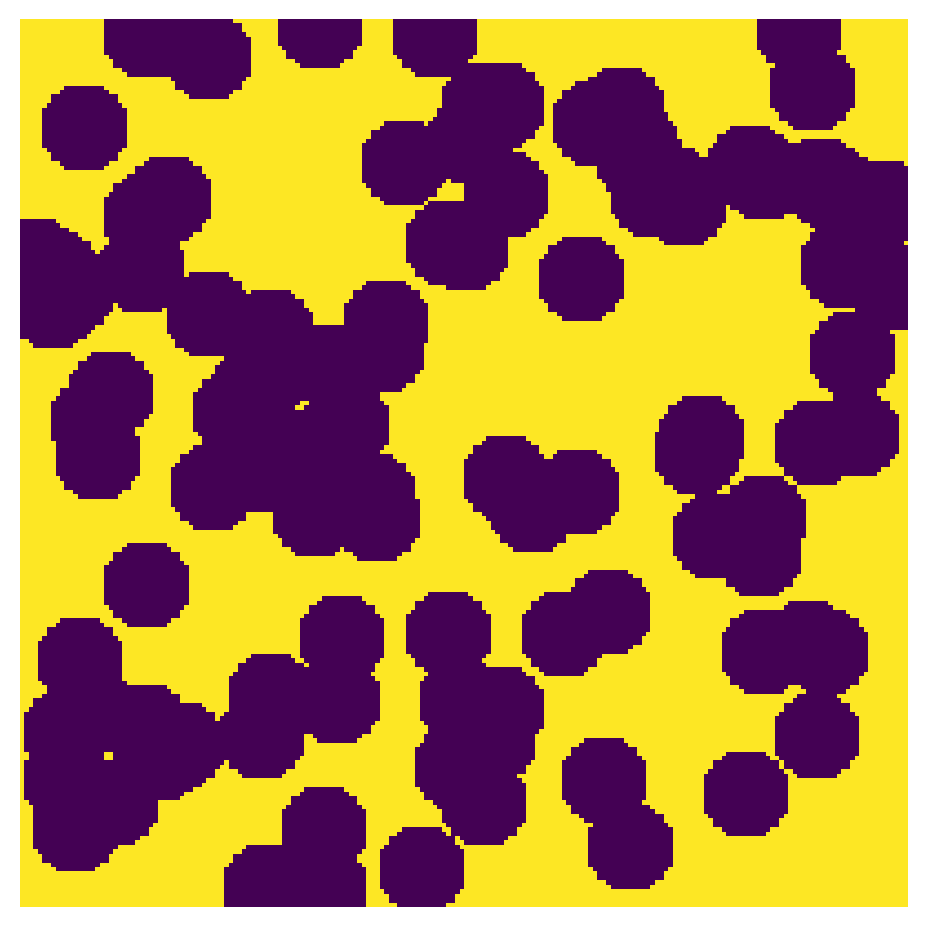

In [2]:
np.random.seed(2)
im = ps.generators.overlapping_spheres([200, 200], r=10, porosity=0.5)
fig, ax = plt.subplots()
ax.imshow(im, origin='lower', interpolation='none')
ax.axis(False)

### Trimming non-percolating pores

Non-percolating pores should be trimmed to reduce calculation requirements. The image must then be checked to ensure precolation is still occuring. This can be done using `check_percolating`. The returned result is the trimmed image. If the image no longer percolates, an error is thrown instead.

[10:41:30] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=32123;file://D:\CS\porespy\src\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=849741;file://D:\CS\porespy\src\porespy\simulations\_dns.py#47\47]8;;\

(-0.5, 199.5, -0.5, 199.5)

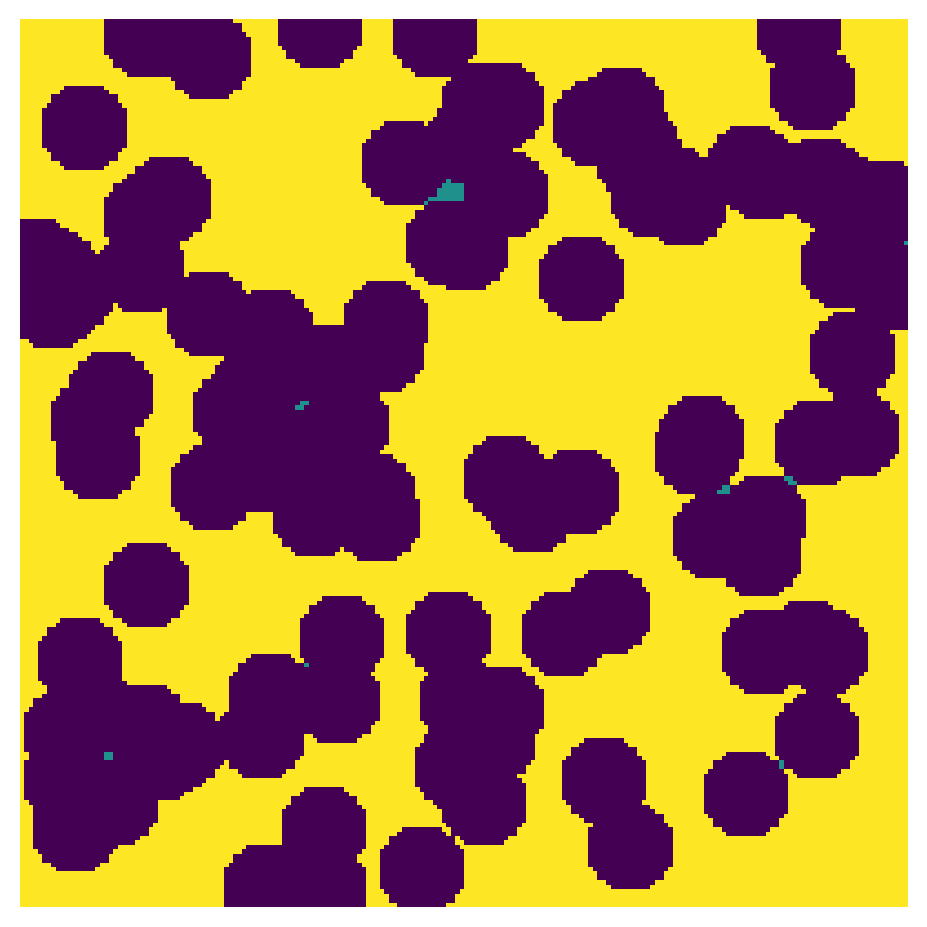

In [3]:
trimmed_im = ps.simulations.check_percolating(im, 1)
fig, ax = plt.subplots()
ax.imshow(trimmed_im + (im != trimmed_im) * 0.5)
ax.axis(False)

### Performing Fickian Diffusion

openpnm's Fickian diffusion algorithm is applied on the specified axis.

The result from `fickian_diffusion` contains two attributes:

|Attribute| Description |
|-|-|
|`r_in` |Molar Flowrate into the image |
|`concentration_map` |Concentration map of the image |

The concentration map can be accessed by using `object.attribute`, or in this case, `diffusion_results.concentration_map`.

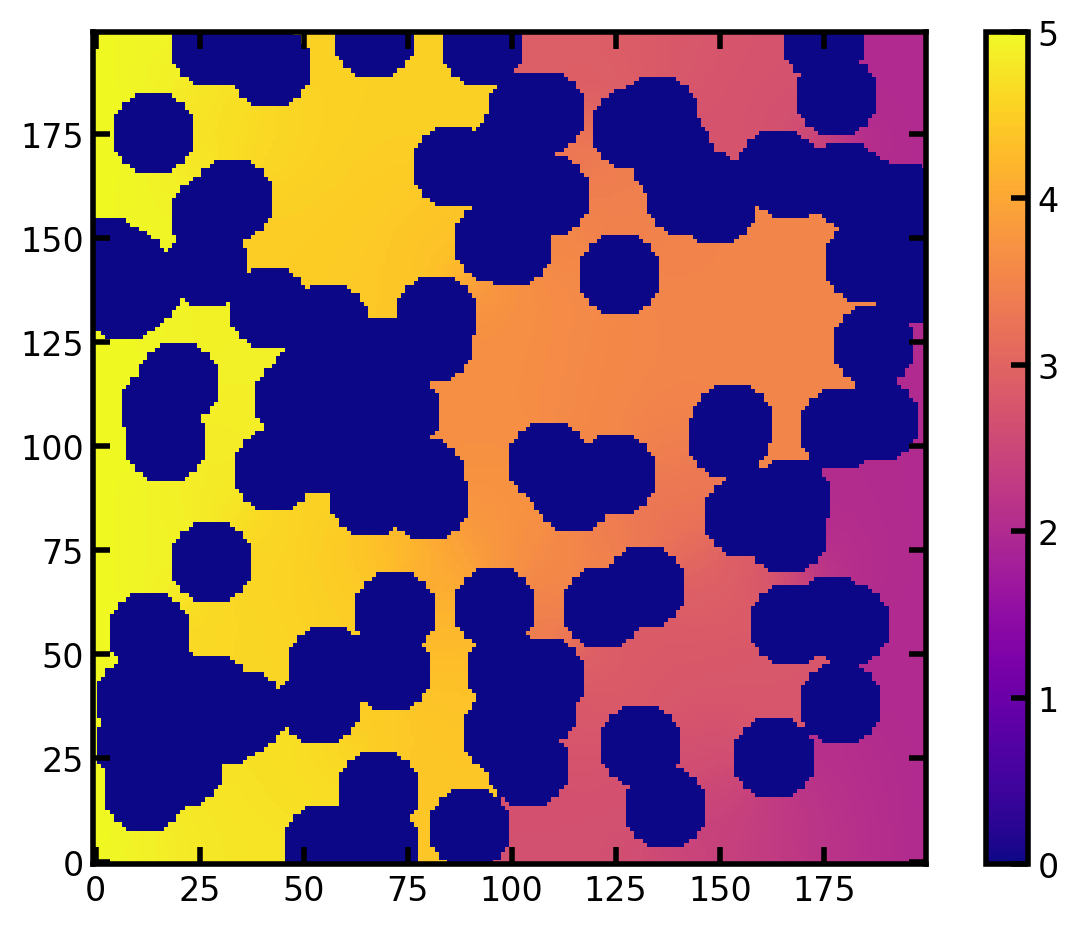

In [4]:
diffusion_results = ps.simulations.fickian_diffusion(im=trimmed_im, axis=1, cL=5, cR=2)

plt.imshow(diffusion_results.concentration_map, origin='lower', interpolation='none', cmap=plt.cm.plasma)
plt.colorbar()

### Running the algorithm

As mentioned at the start of the tutorial, the only two inputs for the function are the image and the axis along which to run the calculation. For the x-axis we assign axis a value of 1 and for the y-axis we assign axis a value of 0.

In [5]:
results = ps.simulations.tortuosity_fd(im=trimmed_im, axis=1, r_in=diffusion_results.r_in)
print(results)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Mon Jul  8 10:41:32 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200)
tortuosity                1.345433860454569
formation_factor          2.692887386448975
porosity                  0.499625
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The function outputs an object with several attributes: 

|Attribute| Description |
|-|-|
|``im``|The image supplied to the function
|``tortuosity``|The **calculated tortuosity** is given by the equation:<br> <br>$$\tau = \frac{D_{AB}}{D_{Eff}} \cdot \varepsilon $$<br><br> where $\varepsilon$ is the ``effective_porosity``|
|``formation_factor``|The formation factor is given by the equation: <br><br>$$\mathscr{F}=\frac{D_{AB}}{D_{Eff}}$$|
|``porosity``|The porosity of the image as inputted|

### Calling Values From The Output

There are a couple ways to call the values from the returned object. The easiest way to call the values is to use object.attribute

In [6]:
results.tortuosity

1.345433860454569